In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Imports and data loading

## General imports

In [2]:
import os
import gc
import sys
import cv2
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from google.colab import files
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold


!pip uninstall kaggle -q
!pip install kaggle -q
!pip install tensorflow==1.5 -q
!pip install keras==2.1.5 -q

import keras
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Proceed (y/n)? y
     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 44.4MB 67kB/s 
     |████████████████████████████████| 3.0MB 51.2MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
     |████████████████████████████████| 337kB 9.1MB/s 


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarn

## Download dataset

In [4]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c imaterialist-fashion-2020-fgvc7

Saving kaggle.json to kaggle.json
100% 19.2G/19.2G [04:22<00:00, 79.5MB/s]
100% 19.2G/19.2G [04:22<00:00, 78.5MB/s]


In [5]:
!unzip -qq '/content/imaterialist-fashion-2020-fgvc7.zip'

In [6]:
with open('/content/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
sample_sub_df = pd.read_csv('/content/sample_submission.csv')
train_df = pd.read_csv('/content/train.csv')

## Clone Mask_RCNN and import it

In [7]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git
!rm -rf images assets

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [8]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [9]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


# Preproccesing

In [10]:
DATA_DIR = '/content'
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

In [ ]:
def create_mask(image_id):
    masks = []

    img = mpimg.imread(f'/content/train/{image_id}.jpg')
    shape = img.shape
    encoded_pixels = list(train_df[train_df['ImageId'] == image_id]['EncodedPixels'])
    class_ids = list(train_df[train_df['ImageId'] == image_id]['ClassId'])
      
    # Initialize numpy array with shape same as image size
    height, width = shape[:2]
    mask = np.zeros((height, width)).reshape(-1)
      
    # Iterate over encoded pixels and create mask
    for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
        splitted_pixels = list(map(int, pixel_str.split()))
        pixel_starts = splitted_pixels[::2]
        run_lengths = splitted_pixels[1::2]
        assert max(pixel_starts) < mask.shape[0]
        for pixel_start, run_length in zip(pixel_starts, run_lengths):
            mask[int(pixel_start) - 1 : int(pixel_start) - 1 + int(run_length)] = 255 - class_id * 4
    masks.append(mask.reshape((height, width), order='F'))
    return masks

In [ ]:
def create_mask(size):
    image_ids = train_df['ImageId'].unique()[:size]
    images_meta=[]
    masks = []

    for image_id in image_ids:
        img = mpimg.imread(f'/content/train/{image_id}.jpg')
        shape = img.shape
        encoded_pixels = list(train_df[train_df['ImageId'] == image_id]['EncodedPixels'])
        class_ids = list(train_df[train_df['ImageId'] == image_id]['ClassId'])
        
        images_meta.append({
            'image': img,
            'shape': shape,
            'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
            'class_ids': train_df[train_df['ImageId'] == image_id]['ClassId']
        })
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                mask[int(pixel_start) - 1 : int(pixel_start) - 1 + int(run_length)] = 255 - class_id * 4
        masks.append(mask.reshape((height, width), order='F'))
    return masks, images_meta

In [ ]:
def plot_segmented_images(size=4, figsize=(14, 14)):
    # First create masks from given segments
    masks, images_meta = create_mask(size)
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images_meta[count]['image'])
                col.imshow(masks[count], alpha=0.75)
                col.title.set_text('Categories:\n' \
                                   + ', '.join(["[" + categories_df[categories_df.id == x].name.values[0] + "]"\
                                                for x in images_meta[count]['class_ids'].values]))
                col.axis('off')
                count += 1
        plt.show()
    gc.collect()

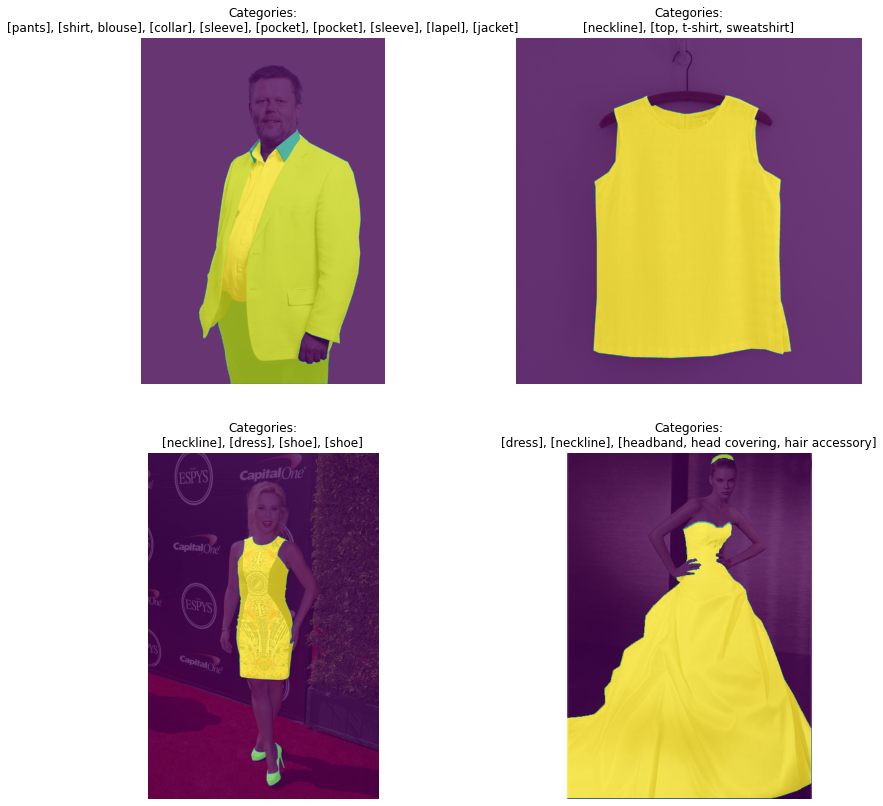

In [ ]:
plot_segmented_images()

In [11]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [12]:
categories_df = pd.DataFrame(label_desc.get('categories'))

In [13]:
image_df = train_df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = train_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [14]:
class FashionConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "class"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(categories_df)  # background + 46 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
        
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [15]:
class FashionDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256
        
        # Add classes
        for cat in label_desc['categories']:
            self.add_class('fashion', cat.get('id'), cat.get('name'))
        
        # Add images
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=DATA_DIR + os.sep + 'train' + os.sep + row.name + '.jpg', 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
            
    def _resize_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
        return img
        
    def load_image(self, image_id):
        return self._resize_image(self.image_info[image_id]['path'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

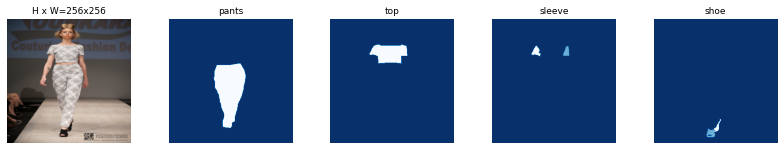

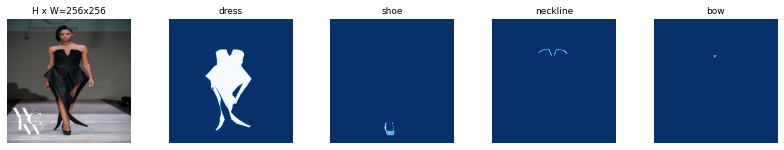

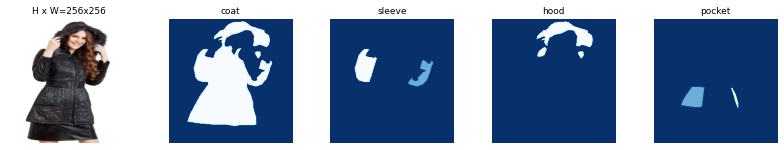

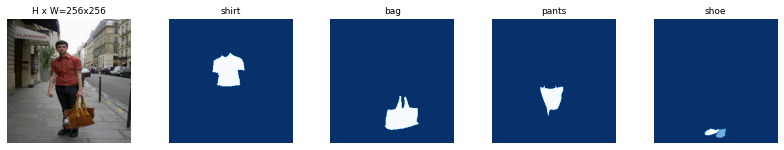

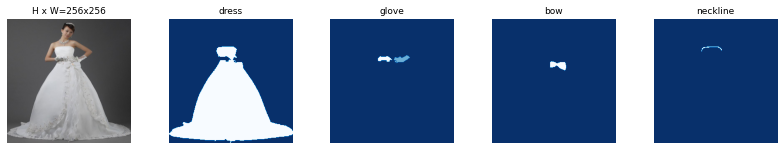

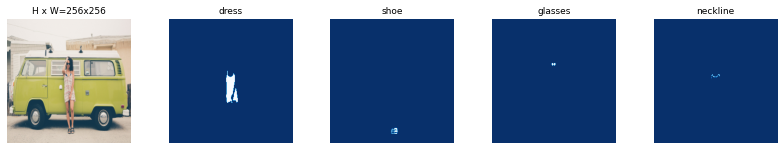

In [16]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)

    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [17]:
FOLD = 0
N_FOLDS = 2

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

In [ ]:
LR = 1e-4
EPOCHS = [1, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content')

# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[2],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /content/class20200731T1855/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

In [ ]:
 11/100 [==>...........................] - ETA: 2:31:53 - loss: 9.5498 - rpn_class_loss: 0.2043 - rpn_bbox_loss: 2.9464 - mrcnn_class_loss: 4.2737 - mrcnn_bbox_loss: 1.1527 - mrcnn_mask_loss: 0.9727
 30/100 [========>.....................] - ETA: 1:44:02 - loss: 7.4847 - rpn_class_loss: 0.2134 - rpn_bbox_loss: 2.7161 - mrcnn_class_loss: 2.5227 - mrcnn_bbox_loss: 1.0731 - mrcnn_mask_loss: 0.9594
 40/100 [===========>..................] - ETA: 1:27:33 - loss: 6.9475 - rpn_class_loss: 0.2074 - rpn_bbox_loss: 2.5732 - mrcnn_class_loss: 2.2055 - mrcnn_bbox_loss: 1.0372 - mrcnn_mask_loss: 0.9241

In [ ]:
path = '/content/drive/My Drive/projects/iMaterialist (Fashion) 2020 at FGVC7/fashion_maskrcnn_model_8_epochs.h5'
# Save the Keras Model
# keras.models.save_model(model.keras_model,"mask_rcnn_coco.hdf5")

# Save weights
model.keras_model.save_weights(path)

In [18]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [19]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='/content/drive/My Drive/projects/iMaterialist (Fashion) 2020 at FGVC7/')

path = '/content/drive/My Drive/projects/iMaterialist (Fashion) 2020 at FGVC7/fashion_maskrcnn_model_8_epochs.h5'
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", path)
model.load_weights(path, by_name=True)

Loading weights from  /content/drive/My Drive/projects/iMaterialist (Fashion) 2020 at FGVC7/fashion_maskrcnn_model_8_epochs.h5


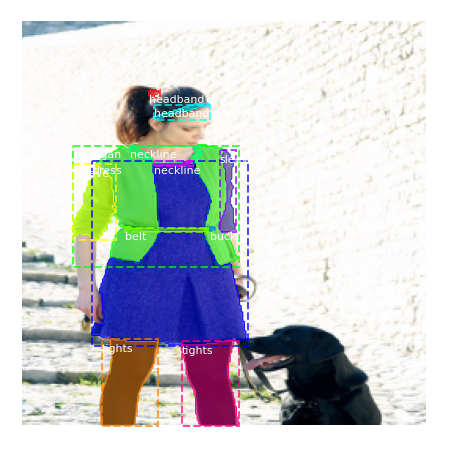

In [ ]:
# Test on a random image
image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

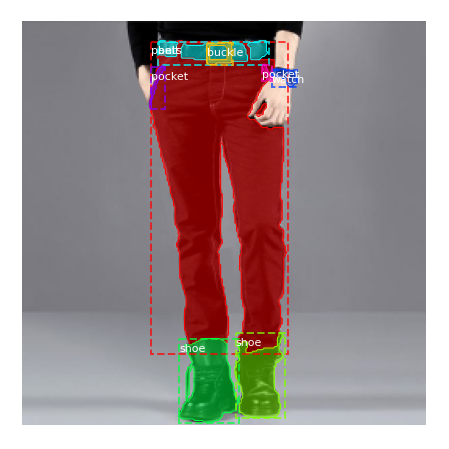

In [ ]:
# Test on a random image
image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

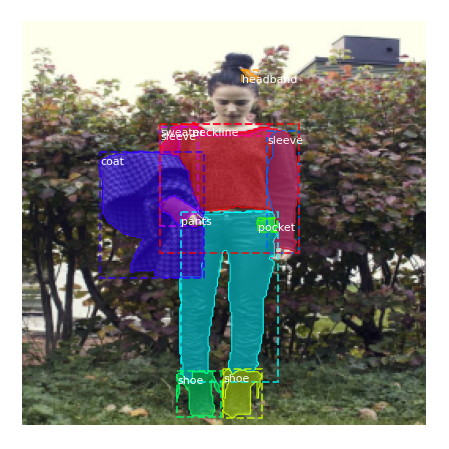

In [ ]:
# Test on a random image
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            valid_dataset.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -120.70000  max:  146.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


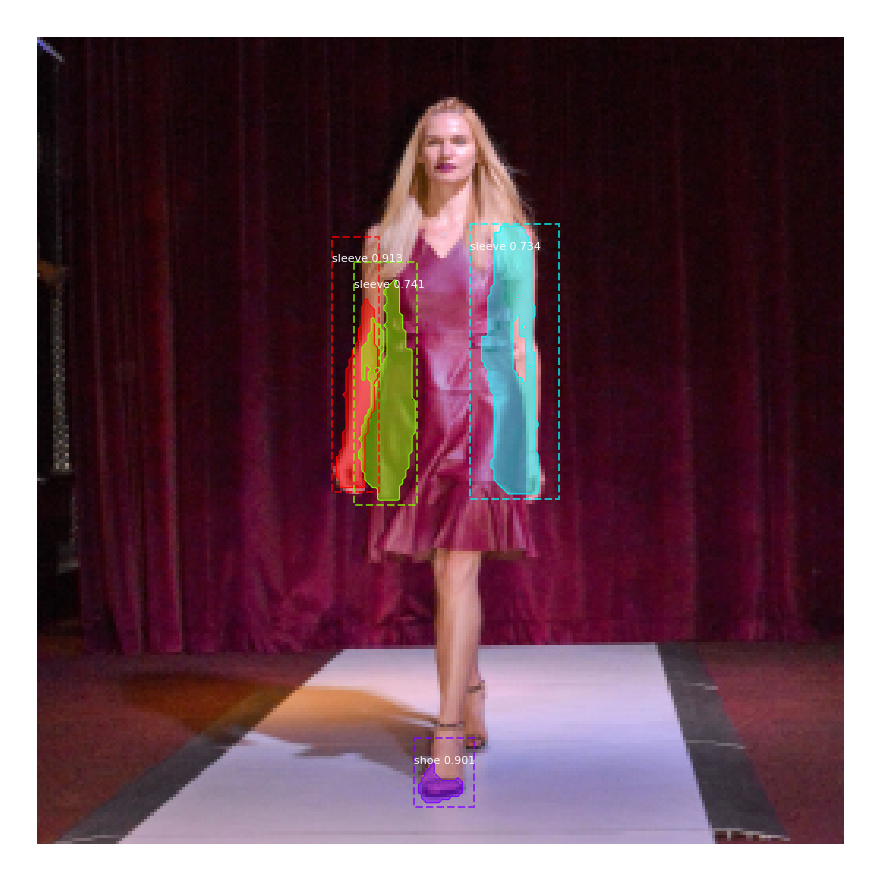

In [25]:
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

def resize_image(original_image):
    img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)  
    return img

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            valid_dataset.class_names, r['scores'], ax=get_ax())